<a href="https://colab.research.google.com/github/mikemenj/sales-predictions/blob/main/Sales_Predictions_Linear_reg_Dec_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sales Predictions**

Student: Michael Menjares

#Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import set_config
set_config(display='diagram')

In [2]:
def csv_link(link):
  # replace /file/d/ with /uc?id=
  link = link.replace('/file/d/', '/uc?id=')

  # remove /view?usp=sharing or /edit from the end of the link
  link = link.replace('/view?usp=sharing', '')
  link = link.replace('/edit', '')
  link = link.replace('/view', '')

  return link

link = 'https://drive.google.com/file/d/1syH81TVrbBsdymLT_jl2JIf6IjPXtSQw/view?usp=sharing'
url = csv_link(link)
url

original_df = pd.read_csv(url)
df = original_df.copy()
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


#Inspect the data

In [3]:
## Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 8523 rows, and 12 columns.
The rows represent 8523 observations, and the columns represent 11 features and 1 target variable.


In [4]:
## Display the column names, count of non-null values, and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


#Clean the Data

## **Duplicates**

In [5]:
## Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


In [6]:
## Drop duplicate rows
df = df.drop_duplicates()

In [7]:
## Confirm duplicate rows have been dropped
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


### **Inspect Column Datatypes for Errors**

In [8]:
## Display column names and datatypes
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

- All collumns appear to have the appropriate data types.

### **Inspect Column Names for Errors**


- Check for common syntax errors which may include extra white spaces at the beginning or end of strings or column names.

- Check for typos or inconsistencies in strings that need to be fixed.(example: cat, Cat, cats)

In [9]:
## Display column names
cols = df.columns
cols

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

- No errors noted.

### **Inspect Values for Errors**

#### **Numeric Columns**

- Check for unusual or impossible values. (Example a weight, or height that is negative in value.)

In [10]:
## Display the descriptive statistics for the non-numeric columns
df.describe(include="number")

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


- No unusual values noted.

### **Missing Values**

In [11]:
## Display the total number of missing values
print(f'There are {df.isna().sum().sum()} missing values.')

There are 3873 missing values.


In [12]:
## Display the count of missing values by column
print(df.isna().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [13]:
## Display the percentage of missing values by column
print(df.isna().sum()/len(df)*100)

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64


#Heatmap of Correlations

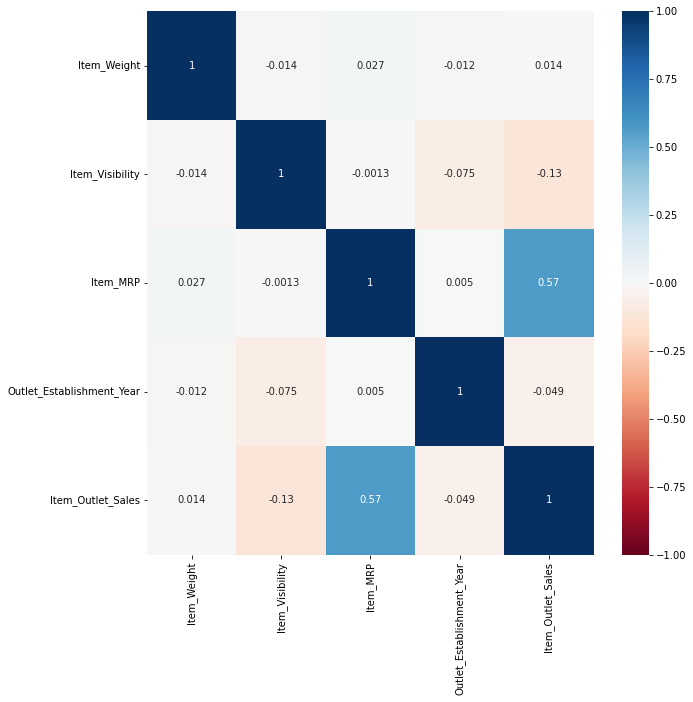

In [14]:
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot = True);

RM, PTRATIO, and LSTAT are highest 3 features that correlate to PRICE

#ID X/y and Train/Test Split

In [21]:
target = 'Item_Outlet_Sales'
other_cols = 'Item_Identifier'
X = df.drop(columns = [target , other_cols])
y = df[target]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#Instantiate and Fit

In [29]:
# Instantiate the transformers
scaler = StandardScaler()
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Prepare separate processing pipelines for numeric and categorical data
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

# Create ColumnSelectors for the the numeric and categorical data
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Combine the Pipelines and ColumnSelectors into tuples for the ColumnTransformer
cat_tuple = (cat_pipe, cat_selector)
num_tuple = (num_pipe, num_selector)

# Create the preprocessing ColumnTransformer
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f41d71be2b0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f41d71be2e0>)])

In [30]:
# Instantiate
reg = LinearRegression()

add model to preprocessor to create a model pipeline

In [31]:
#linear regression model in a Pipeline
reg_pipe = make_pipeline(preprocessor, reg)
reg_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f41d71be2b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f41d71be2e0>)])),
                ('linearregression', LinearRegression())])

In [34]:
# Fit the model pipeline on the training data
reg_pipe.fit(X_train, y_train)

# Make predictions using the training and testing data
reg_training_predictions = reg_pipe.predict(X_train)
reg_test_predictions = reg_pipe.predict(X_test)
reg_training_predictions[:10]

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([3824., 2656., 2672., 1472., 1840., -136., 1600., 5624., 4272.,
       2064.])

#Evaluate Model

In [35]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics
def model_metrics(pipe, X_train, y_train, X_test, y_test, 
                       model_name='Regression Model', ):
  
  """Takes a regression model, training features and target and testing features and target.
  Returns a dataframe of regression metrics"""

  ## Predictions
  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)
  
  metrics = ['train_MAE','test_MAE', 
             'train_RMSE', 'test_RMSE', 
             'train_R2', 'test_R2']
  
  ## Train
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),7)

  ## Test
  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),7)

  ## Output Dataframe
  scores = pd.DataFrame(index=metrics, columns=[f'{model_name}_test'])
  scores.loc[metrics, f'{model_name}_test'] = [train_mae, test_mae,
                                               train_rmse, test_rmse,
                                               train_r2, test_r2]

  return scores

In [37]:
model_metrics(reg_pipe, X_train, y_train, X_test, y_test, model_name = 'Linear Regression Model')

,Linear Regression Model_test
train_MAE,849.6273
test_MAE,807.3546
train_RMSE,1140.8251
test_RMSE,1096.6179
train_R2,0.560229
test_R2,0.564124


Reg Tree

In [40]:
dt = DecisionTreeRegressor(random_state=42)

In [41]:
dt_pipe = make_pipeline(preprocessor, dt)
dt_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f41d71be2b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f41d71be2e0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [42]:
# Fit the model pipeline on the training data
dt_pipe.fit(X_train, y_train)

# Make predictions using the training and testing data
dt_training_predictions = reg_pipe.predict(X_train)
dt_test_predictions = reg_pipe.predict(X_test)
dt_training_predictions[:10]

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([3824., 2656., 2672., 1472., 1840., -136., 1600., 5624., 4272.,
       2064.])

In [43]:
model_metrics(dt_pipe, X_train, y_train, X_test, y_test, model_name = 'Regression Regression Model')

,Regression Regression Model_test
train_MAE,0.0
test_MAE,1037.7232
train_RMSE,0.0
test_RMSE,1480.1864
train_R2,1.0
test_R2,0.205883
